In [66]:
import pandas as pd 
import numpy as np
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

1. Carga de datos:
- Descarga y carga el dataset de Kaggle. Realiza una exploración inicial del dataset, identificando las variables que consideras importantes para el agrupamiento.
- El dataset contiene información sobre diferentes tipos de clientes y su comportamiento de compra, lo que incluye variables como el gasto anual en distintas categorías de productos.


In [67]:
data_path_train='../ejercicios_core/data/Wholesale customers data.csv'
df = pd.read_csv(data_path_train)

df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


2. Exploración y preprocesamiento de datos:
- Realiza un análisis exploratorio de los datos, incluyendo un resumen estadístico de las variables. Es importante entender la distribución de los datos antes de aplicar el modelo de DBSCAN.
- Asegúrate de estandarizar los datos antes de ejecutar DBSCAN, ya que este algoritmo es sensible a la escala de las variables.
- Considera la posibilidad de eliminar o tratar valores atípicos que puedan afectar el rendimiento del algoritmo.


In [68]:
utils.exploracion_inicial(df)

Informacion del dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None
   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404              

In [69]:
utils.estadisticas_descriptivas(df)

Estadisticas del dataset
          Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000    2.000000    3127.750000   1533.000000   2153.000000   
50%      1.000000    3.000000    8504.000000   3627.000000   4755.500000   
75%      2.000000    3.000000   16933.750000   7190.250000  10655.750000   
max      2.000000    3.000000  112151.000000  73498.000000  92780.000000   

             Frozen  Detergents_Paper    Delicassen  
count    440.000000        440.000000    440.000000  
mean    3071.931818       2881.493182   1524.870455  
std     4854.673333       4767.854448   2820.105937  
min       25.000000          3.000000      3.000000  
25%      742.250000 

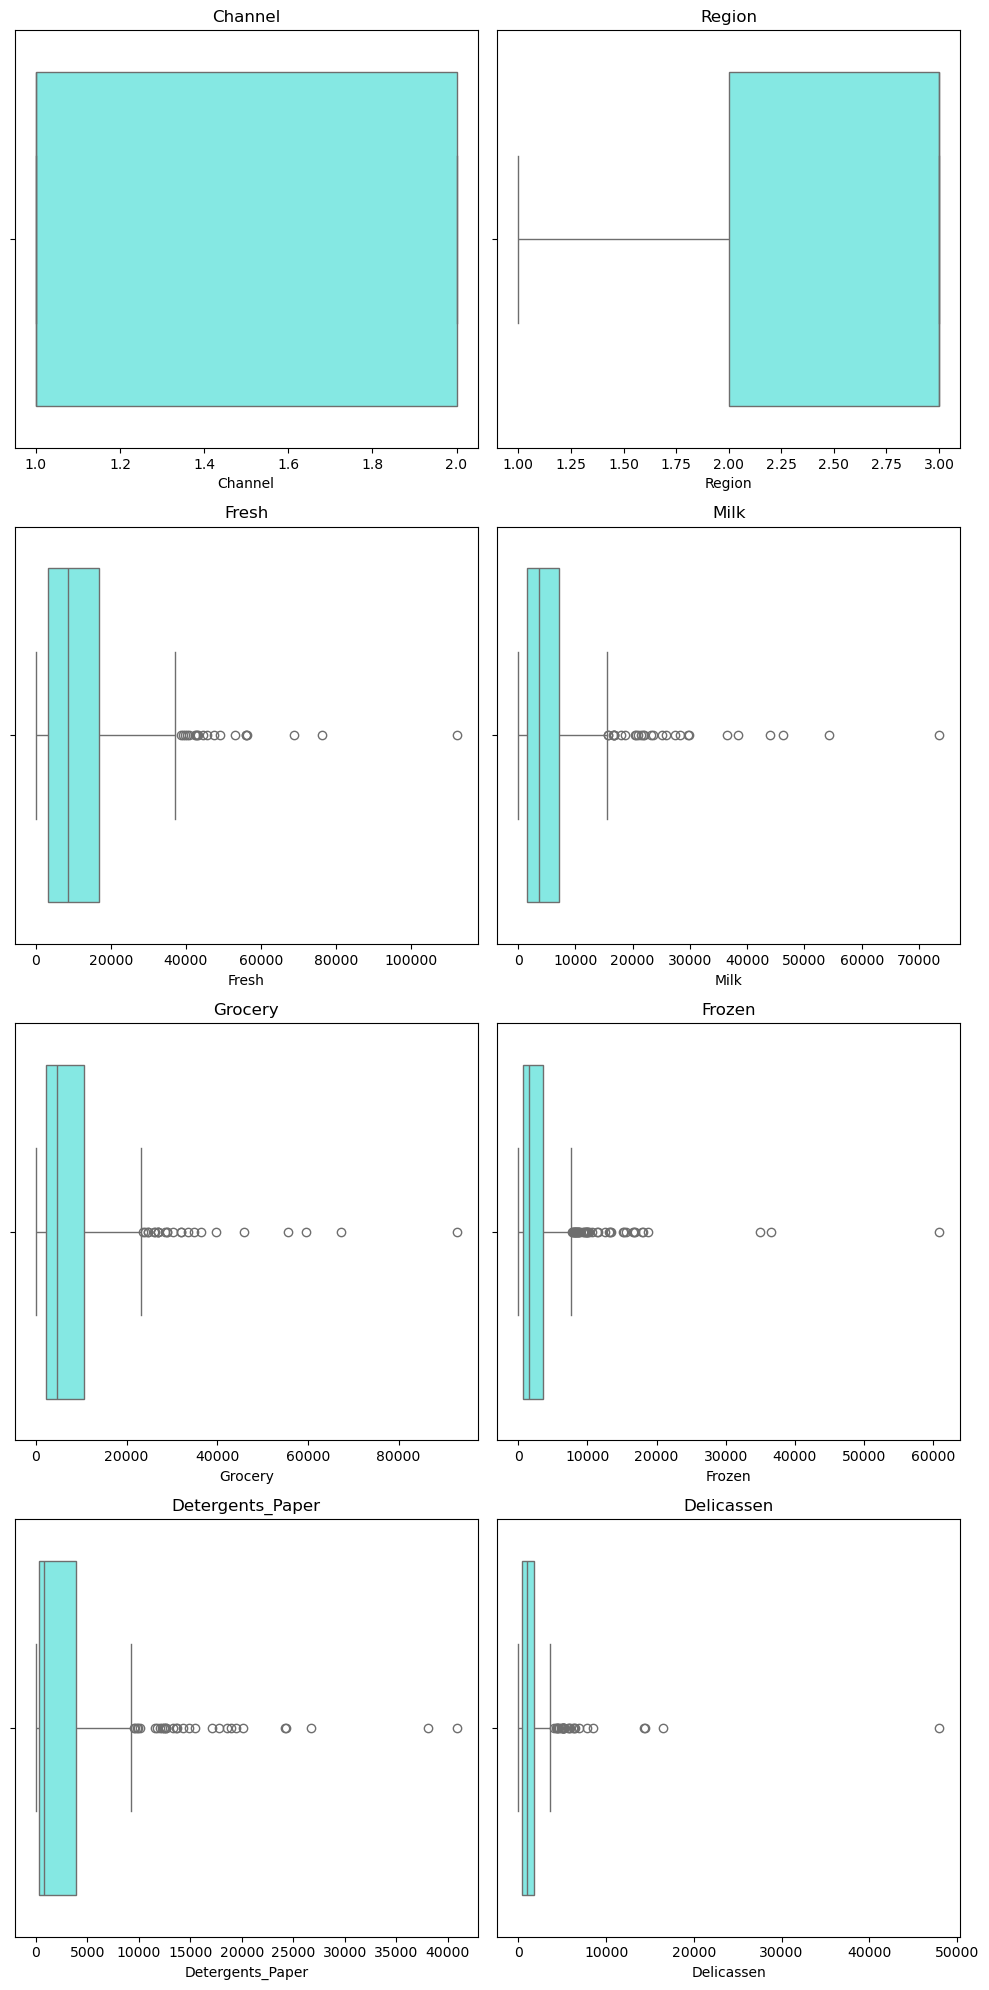

In [70]:
utils.plot_grafico_outliers(df,4,2,df)

In [71]:
# Estandarización de las variables numéricas
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numerical_columns])
# Convertir a DataFrame para facilitar el análisis
df_scaled_pd = pd.DataFrame(df_scaled, columns=numerical_columns)

In [72]:
# Identificación y tratamiento de valores atípicos (Outliers)
# Usamos el método IQR (Interquartile Range) para detectar outliers
Q1 = df_scaled_pd.quantile(0.25)
Q3 = df_scaled_pd.quantile(0.75)
IQR = Q3 - Q1

# Identificar valores atípicos
outliers = ((df_scaled_pd < (Q1 - 1.5 * IQR)) | (df_scaled_pd > (Q3 + 1.5 * IQR)))
print("Número de outliers detectados por columna:")
print(outliers.sum())

Número de outliers detectados por columna:
Channel              0
Region               0
Fresh               20
Milk                28
Grocery             24
Frozen              43
Detergents_Paper    30
Delicassen          27
dtype: int64


In [73]:
## Se tienen en cuenta solo los features relevantes, los cuales seran modificados de acuerdo a la media 
def modificar_outliers_iqr(df, features):
    # Crear una copia del DataFrame original
    df_modificado = df.copy()##Creacion de copia del dataframe para realizar la modificacion sin afectar el dataframe 
    
    for col in features:
        # Calcular el primer y tercer cuartil
        Q1 = df_modificado[col].quantile(0.25)  # Primer cuartil
        Q3 = df_modificado[col].quantile(0.75)  # Tercer cuartil
        IQR = Q3 - Q1  # Rango intercuartil

        # Límites inferior y superior para considerar outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identificar índices de outliers
        outlier_indices = df_modificado[(df_modificado[col] < lower_bound) | (df_modificado[col] > upper_bound)].index
        
        # Calcular la media de la columna
        mean_value = df_modificado[col].mean()
        
        # Reemplazar outliers con la media convertida a tipo compatible
        df_modificado.loc[outlier_indices, col] = mean_value.astype(df_modificado[col].dtype)
    
    
    return df_modificado

# Aplicacion del detector
outliers_detectados = modificar_outliers_iqr(df, numerical_columns)

outliers_detectados ## imprime dataset modificado

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,1524
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,1524
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,3071,182,2204
436,1,3,12000,1431,764,4510,93,2346
437,2,3,14531,15488,7951,437,2881,1867
438,1,3,10290,1981,2232,1038,168,2125


3. Aplicación de DBSCAN:

* Implementa el algoritmo DBSCAN en el dataset. Recuerda que DBSCAN tiene dos hiperparámetros importantes: epsilon (distancia máxima para considerar dos puntos como vecinos) y min_samples (número mínimo de puntos requeridos para formar un cluster).

* Experimenta con diferentes valores de epsilon y min_samples para obtener agrupamientos significativos. Utiliza técnicas visuales como gráficos de dispersión para evaluar los resultados obtenidos.

* Determina cuáles son los outliers identificados por DBSCAN y visualiza cómo se distribuyen en relación con los clusters formados.

Silhouette Score: -0.1310428843570635


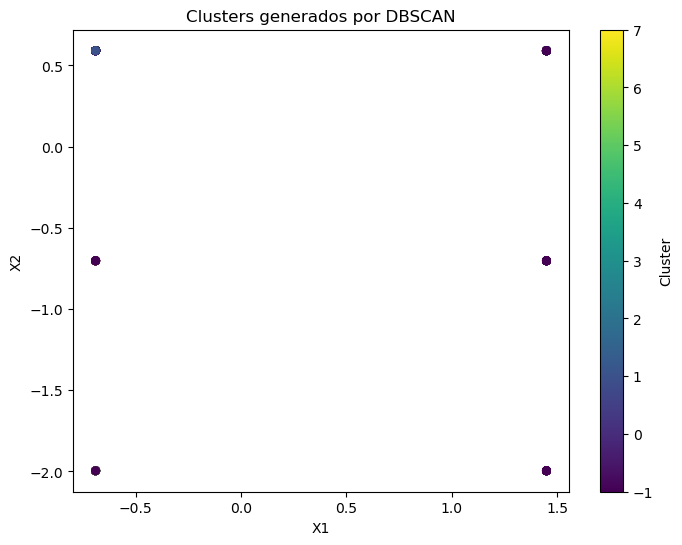

In [74]:
# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(df_scaled)

# Añadir la columna de clusters al dataframe original
df['cluster'] = clusters

# Calcular el Silhouette Score
if len(set(clusters)) > 1:  # Asegurarnos de que haya más de 1 cluster
    score = silhouette_score(df_scaled, clusters)
    print(f"Silhouette Score: {score}")
else:
    print("No es posible calcular el Silhouette Score con un solo cluster.")

# Visualizar los clusters generados por DBSCAN
plt.figure(figsize=(8, 6))
plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=clusters, cmap='viridis', s=30)
plt.title("Clusters generados por DBSCAN")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Cluster")
plt.show()


In [75]:
param_grid = {
    'eps': np.arange(0.05, 0.5, 0.01),
    'min_samples': range(1, 15, 1)
}

# Crear combinaciones de parámetros
grid = ParameterGrid(param_grid)

# Variable para almacenar los mejores parámetros y resultados
best_params = None
best_score = -1
results = []

# Iterar sobre todas las combinaciones de parámetros
for params in grid:
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    clusters = dbscan.fit_predict(df_scaled)
    # Calcular el Silhouette Score solo si hay más de un cluster
    if len(set(clusters)) > 1 and -1 in clusters:
        score = silhouette_score(df_scaled, clusters)
        results.append((params['eps'], params['min_samples'], score))
        if score > best_score:
            best_score = score
            best_params = params

# Convertir resultados en un array para facilitar gráficos
results = np.array(results)

# Resultados óptimos
print(f"Mejores parámetros: {best_params}")
print(f"Mejor Silhouette Score: {best_score:.4f}")

# Si quieres graficar, aquí tienes las variables:
# - results[:, 0]: eps
# - results[:, 1]: min_samples
# - results[:, 2]: silhouette scores

Mejores parámetros: {'eps': 0.49000000000000005, 'min_samples': 12}
Mejor Silhouette Score: 0.0335


In [76]:
# Interpretación de los Resultados
# Evaluación de la calidad del agrupamiento
# Ver cuántos puntos están asignados a cada cluster y los outliers (-1)
print("Distribución de los clusters encontrados:")
print(df['cluster'].value_counts())

# Identificar los outliers
outliers_count = df[df['cluster'] == -1].shape[0]
print(f"Número de outliers detectados: {outliers_count}")

Distribución de los clusters encontrados:
cluster
-1    255
 1    130
 5     22
 4      7
 6      6
 0      5
 3      5
 2      5
 7      5
Name: count, dtype: int64
Número de outliers detectados: 255
